What can i try to add to my model to make it better.

- masks
- attention
- batch normalisation
- POS Tagging or Syntax Parsing: Train the model to predict part-of-speech tags or parse trees alongside character prediction to provide additional linguistic context.
- Subword Information: Use subword units (like byte-pair encoding) to create embeddings that are sensitive to character composition, improving the handling of rare or out-of-vocabulary words.
- remove punctuation

In [1]:
import glob
import os
from google.colab import files
import matplotlib.pyplot as plt
import random
from IPython.display import clear_output
import numpy as np
import math

import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils import clip_grad_norm_
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch.cuda.amp import GradScaler, autocast
from torch.optim.lr_scheduler import OneCycleLR
from torch.optim.lr_scheduler import ReduceLROnPlateau, StepLR


# 1. Data Preparation

## Load Data
First we need to load our data and see if it was loaded properly. We will also see the list of characters used in the text. This first examinetions will tell us how to process the data in next steps

In [2]:
file_path = '/content/Pan Tadeusz.txt'

# Check if the file exists in the specified directory
if os.path.exists(file_path):
    print(f"The file exists: {file_path}")
else:
    print("The file does not exist in the specified directory.")

The file exists: /content/Pan Tadeusz.txt


In [3]:
text_raw = open(file_path, 'r').read().lower()
print(text_raw[:300])

litwo! ojczyzno moja! ty jesteś jak zdrowie:
ile cię trzeba cenić, ten tylko się dowie,
kto cię stracił. dziś piękność twą w całej ozdobie
widzę i opisuję, bo tęsknię po tobie.

    panno święta, co jasnej bronisz częstochowy
i w ostrej świecisz bramie! ty, co gród zamkowy
nowogródzki ochraniasz z j


In [4]:
characters = sorted(set(text_raw))
print(characters)
print(len(characters))

['\n', ' ', '!', '(', ')', '*', ',', '-', '.', '/', '1', '2', '8', ':', ';', '?', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '«', '»', 'ó', 'ą', 'ć', 'ę', 'ł', 'ń', 'ś', 'ź', 'ż', '—', '…']
55


In [5]:
len(text_raw)

445243

## Preprocessing
Now that we have some idea about the text we got we can begin processing it. First i will remove characters that are wrong like numbers or will not be usefull. (to many characters unneceserily increases complexity of paterns that our model will try to capture)

### Remove characters

In [6]:
chars_to_remove = '()*-/128«»—…!:;?,.'
for char in chars_to_remove:
    text_raw = text_raw.replace(char, '')

len(text_raw)

427397

In [7]:
characters = sorted(set(text_raw))
print(characters)
print(len(characters))

['\n', ' ', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'ó', 'ą', 'ć', 'ę', 'ł', 'ń', 'ś', 'ź', 'ż']
37


### Remove unneccesery lines

In [8]:
text_lines = text_raw.split('\n')
print(text_lines[:3])

['litwo ojczyzno moja ty jesteś jak zdrowie', 'ile cię trzeba cenić ten tylko się dowie', 'kto cię stracił dziś piękność twą w całej ozdobie']


In [9]:
def count_length_lines(text):
    tekst_lines = text.split("\n")
    line_length_counts = {}

    for l in tekst_lines:
        words = l.split(" ")
        length = len(words)

        if length in line_length_counts:
            line_length_counts[length] += 1
        else:
            line_length_counts[length] = 1

    for length in sorted(line_length_counts.keys()):
        print(f"Lines with {length} words: {line_length_counts[length]}")

    # Plotting the line lengths
    lengths = list(line_length_counts.keys())
    counts = list(line_length_counts.values())

    plt.figure(figsize=(15, 6))
    plt.bar(lengths, counts, color='blue')
    plt.xlabel('Number of Words in Line')
    plt.ylabel('Number of Lines')
    plt.title('Distribution of Line Lengths')
    plt.xticks(lengths)
    plt.show()


Lines with 1 words: 878
Lines with 2 words: 40
Lines with 3 words: 29
Lines with 4 words: 175
Lines with 5 words: 951
Lines with 6 words: 2343
Lines with 7 words: 2787
Lines with 8 words: 1840
Lines with 9 words: 802
Lines with 10 words: 395
Lines with 11 words: 251
Lines with 12 words: 158
Lines with 13 words: 56
Lines with 14 words: 24
Lines with 15 words: 1
Lines with 16 words: 1
Lines with 17 words: 1
Lines with 25 words: 2
Lines with 26 words: 3
Lines with 27 words: 15
Lines with 28 words: 21
Lines with 29 words: 12
Lines with 30 words: 7
Lines with 31 words: 2
Lines with 37 words: 1
Lines with 42 words: 1
Lines with 46 words: 1
Lines with 49 words: 1
Lines with 50 words: 1
Lines with 53 words: 1
Lines with 54 words: 1
Lines with 65 words: 1
Lines with 71 words: 1
Lines with 75 words: 1


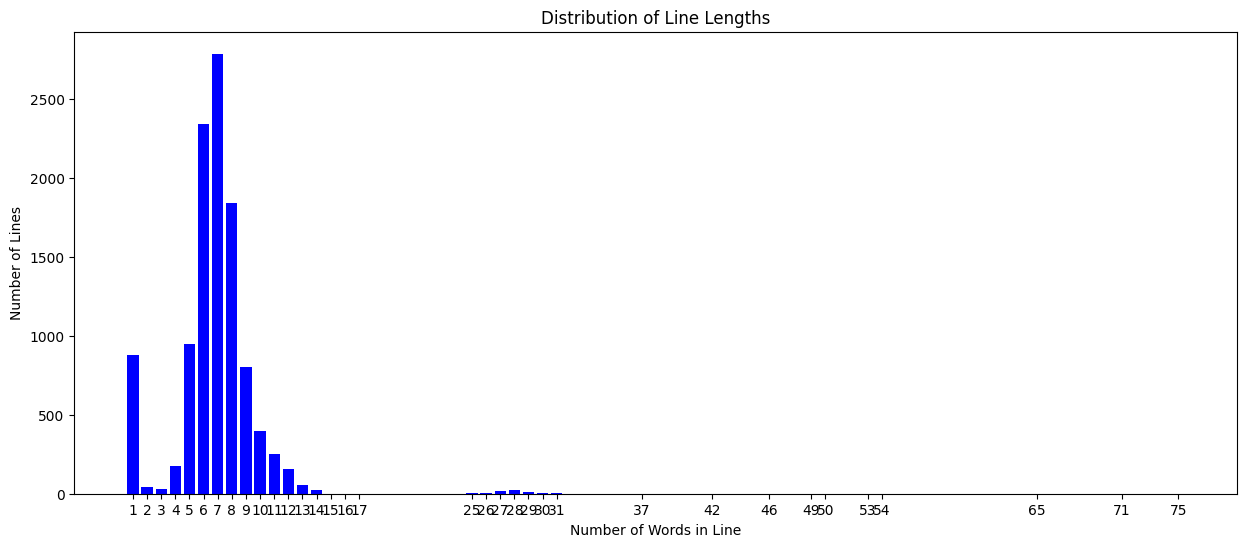

In [10]:
count_length_lines(text_raw)

In [11]:
def show_lines_with_length(text, length):
    lines = text.split("\n")
    for line in lines:
        words = line.split(" ")
        if len(words) == length:
            print(line)

show_lines_with_length(text_raw, 17)

narada tycząca się zabezpieczenia losu zwycięzców  układy z rykowem  pożegnanie  ważne odkrycie  nadzieja


In [12]:
def drop_lines_with_length(text, threshold_low, threshold_high):
    lines = text.split("\n")
    new_text = ""
    for line in lines:
        words = line.split(" ")
        if threshold_low <= len(words) <= threshold_high:
            new_text += line + "\n"
    return new_text

text_processed = drop_lines_with_length(text_raw, 3, 17)

Lines with 1 words: 1
Lines with 3 words: 29
Lines with 4 words: 175
Lines with 5 words: 951
Lines with 6 words: 2343
Lines with 7 words: 2787
Lines with 8 words: 1840
Lines with 9 words: 802
Lines with 10 words: 395
Lines with 11 words: 251
Lines with 12 words: 158
Lines with 13 words: 56
Lines with 14 words: 24
Lines with 15 words: 1
Lines with 16 words: 1
Lines with 17 words: 1


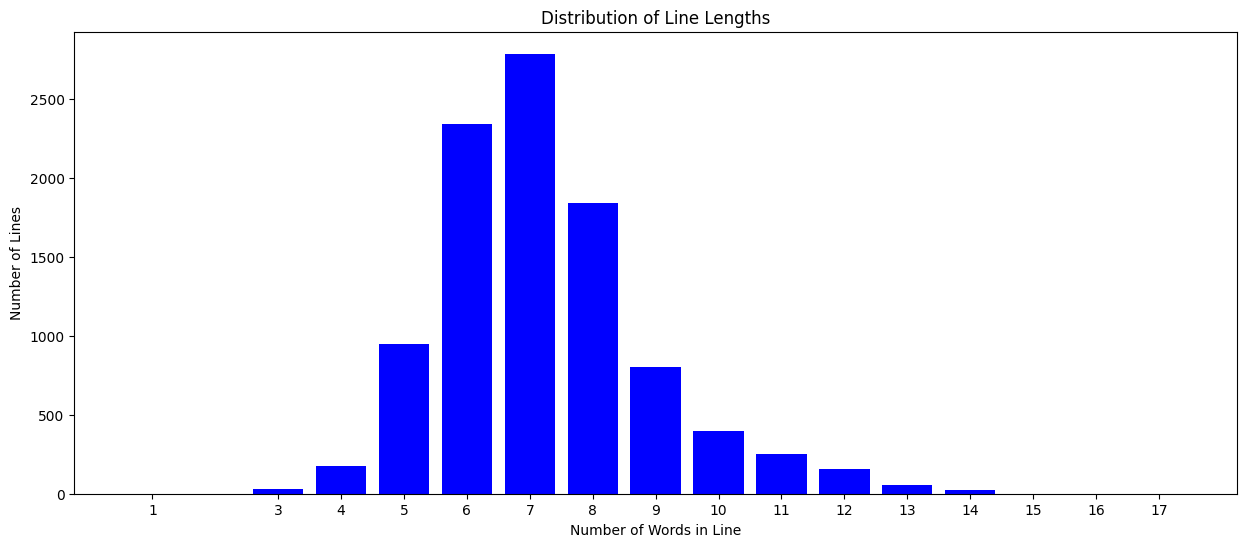

In [13]:
count_length_lines(text_processed)

In [14]:
print(f"Number of lines: {len(text_processed.splitlines())}.")

Number of lines: 9814.


## Tokenisation

In [15]:
int_char_dict = dict(enumerate(sorted((set(text_processed)))))
char_int_dict = {v: k for k, v in int_char_dict.items()}

#print(int_char_dict)
#print(char_int_dict)

encoded = [char_int_dict[char] for char in text_processed]

# 2. Model Building

## Parameters
Because our code can be complex i like to keep all the key parameters in one place where i can convinintly adjust them and have the code dynamically update various inf.

In [16]:
params = {
    'p_context_length': 22,
    'p_prediction_length': 1,
    'p_seed': 42,
    'p_start_idx_dataset': 0,
    'p_step': 1,
    'p_train_dataset': 300000,
    'p_valid_dataset': 30000,
    'p_test_dataset': 30000,

    'rnn_embedding_size': 128,
    'rnn_num_layers': 2,
    'rnn_hidden_size': 512,
    'rnn_input_size': len(char_int_dict),
    'rnn_output_size': len(char_int_dict),
    'rnn_dropout': 0.5,  # Increased dropout
    'rnn_bidirectional': True,

    't_epochs_num': 7,
    't_batch_size': 64,  # Adjusted batch size
    't_criterion': nn.CrossEntropyLoss(),
    't_learning_rate': 0.003,  # Reduced learning rate
    't_momentum': 0.9,
    't_nesterov': True,
    't_scheduler': 'OneCycleLR',
    't_scheduler_max_lr': 0.006,  # Adjusted max learning rate for OneCycleLR
    't_scheduler_total_steps': None,
    't_weight_decay': 5e-6,  # Slightly increased weight decay
    't_print_every': 5,
    't_plot_every': 5,
    't_gradient_clip_value': 5,
}


In [17]:
# Dynamically update 't_scheduler_total_steps' after defining the dictionary
params['t_scheduler_total_steps'] = params['t_epochs_num'] * math.ceil(params['p_train_dataset'] / params['t_batch_size'])


## Dataset & Data Loader

In [18]:
class TextDataset(Dataset):
    def __init__(self, text, start_idx, context_length, prediction_length, char2int, num_samples, step, seed):
        super().__init__()

        # Assert that the text length is sufficient to create the required number of samples
        assert len(text) >= start_idx + num_samples * step + context_length + prediction_length

        self.text = text
        self.context_length = context_length
        self.prediction_length = prediction_length
        self.char2int = char2int
        self.num_samples = num_samples
        self.step = step
        self.start_idx = start_idx
        self.seed = seed
        self.encoded_text = [char2int[char] for char in text]

        # Set the random seed for reproducibility
        random.seed(self.seed)
        np.random.seed(self.seed)

        # Create sequences
        self.input_sequences, self.target_sequences = self.create_sequences()

    def create_sequences(self):
        input_sequences = []
        target_sequences = []
        text_length = len(self.encoded_text)
        start_idx = self.start_idx

        while len(input_sequences) < self.num_samples and start_idx + self.context_length + self.prediction_length <= text_length:
            input_seq = self.encoded_text[start_idx:start_idx + self.context_length]
            target_seq = self.encoded_text[start_idx + self.context_length:start_idx + self.context_length + self.prediction_length]
            input_sequences.append(input_seq)
            target_sequences.append(target_seq)
            start_idx += self.step

        return input_sequences, target_sequences

    def __len__(self):
        return len(self.input_sequences)

    def __getitem__(self, idx):
        input_seq = torch.tensor(self.input_sequences[idx], dtype=torch.long)
        target_seq = torch.tensor(self.target_sequences[idx], dtype=torch.long)

        return input_seq, target_seq


In [19]:
# Create datasets
train_dataset = TextDataset(text_processed,
                            params['p_start_idx_dataset'],
                            params['p_context_length'],
                            params['p_prediction_length'],
                            char_int_dict,
                            params['p_train_dataset'],
                            params['p_step'],
                            params['p_seed'])


# Create DataLoader
train_loader = DataLoader(train_dataset, batch_size=params['t_batch_size'], shuffle=True, num_workers=2)


In [20]:
print(train_dataset.__len__())


300000


In [21]:
# Check the length and some samples from the dataset
print("Train Dataset length:", len(train_dataset))
input_seq, target_seq = train_dataset[123]
print(f"Input Sequence: {input_seq}, \n"
      f"Target Sequence: {target_seq}")

Train Dataset length: 300000
Input Sequence: tensor([11,  1, 16, 27,  5, 16,  3, 10,  6,  0, 24, 10,  5, 27, 31,  1, 10,  1,
        16, 17, 10, 20]), 
Target Sequence: tensor([22])


## Model Architecture

In [22]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, embedding_size, hidden_size, output_size, num_layers, dropout, bidirectional):
        super().__init__()

        self.input_size = input_size
        self.embedding_size = embedding_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers
        self.dropout = dropout
        self.bidirectional = bidirectional

        self.embedding = nn.Embedding(input_size, embedding_size)
        self.lstm = nn.LSTM(embedding_size, hidden_size, num_layers, batch_first=True, dropout=dropout, bidirectional=bidirectional)
        self.normalization = nn.LayerNorm(hidden_size * (2 if bidirectional else 1))
        self.dropout_layer = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size * (2 if bidirectional else 1), output_size)

        self.apply(self._init_weights)  # Apply Xavier Initialization

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            nn.init.xavier_uniform_(module.weight)
        elif isinstance(module, nn.LSTM):
            for name, param in module.named_parameters():
                if 'weight' in name:
                    nn.init.xavier_uniform_(param)

    def forward(self, x, hidden):
        x = self.embedding(x)
        #print(f"embedding shape: {x.shape}")
        lstm_out, hidden = self.lstm(x, hidden)
        #print(f"lstm_out shape: {lstm_out.shape}")
        lstm_out = self.normalization(lstm_out)
        #print(f"normalization shape: {lstm_out.shape}")
        lstm_out = self.dropout_layer(lstm_out)
        #print(f"dropout shape: {lstm_out.shape}")

        output = self.fc(lstm_out)
        #print(f"output shape: {output.shape}")

        output = output[:, -params['p_prediction_length']:, :]
        #print(f"extracted output shape: {output.shape}")

        return output, hidden

    def init_hidden(self, batch_size, device):
        weight = next(self.parameters()).data
        num_directions = 2 if self.bidirectional else 1
        hidden = (weight.new_zeros(self.num_layers * num_directions, batch_size, self.hidden_size).to(device),
                  weight.new_zeros(self.num_layers * num_directions, batch_size, self.hidden_size).to(device))
        return hidden


## Training Loop

### Learning rate finder

In [23]:
def find_lr(model, train_loader, criterion, optimizer, init_value=1e-8, final_value=10.0, beta=0.98):
    num = len(train_loader) - 1
    mult = (final_value / init_value) ** (1/num)
    lr = init_value
    optimizer.param_groups[0]['lr'] = lr
    avg_loss = 0.0
    best_loss = 0.0
    batch_num = 0
    losses = []
    log_lrs = []

    for input_seq, target_seq in train_loader:
        batch_num += 1
        input_seq, target_seq = input_seq.to(device), target_seq.to(device)

        # Reset gradients
        optimizer.zero_grad()

        # Forward pass
        output, hidden = model(input_seq, model.init_hidden(input_seq.size(0), device))
        loss = criterion(output.reshape(-1, model.output_size), target_seq.reshape(-1))

        # Compute the smoothed loss
        avg_loss = beta * avg_loss + (1 - beta) * loss.item()
        smoothed_loss = avg_loss / (1 - beta**batch_num)

        # Stop if the loss is exploding
        if batch_num > 1 and smoothed_loss > 4 * best_loss:
            return log_lrs, losses

        # Record the best loss
        if smoothed_loss < best_loss or batch_num == 1:
            best_loss = smoothed_loss

        # Store the values
        losses.append(smoothed_loss)
        log_lrs.append(lr)

        # Backward pass
        loss.backward()

        # Clip gradients
        clip_grad_norm_(model.parameters(), params['t_gradient_clip_value'])

        # Update parameters
        optimizer.step()

        # Update learning rate
        lr *= mult
        optimizer.param_groups[0]['lr'] = lr

    return log_lrs, losses


### Xavier weight initialization

In [24]:
# Xavier Initialization
def weights_init(m):
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        nn.init.xavier_uniform_(m.weight)

### Early stopping

In [25]:
class EarlyStopping:
    def __init__(self, patience=10, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = float('inf')
        self.delta = delta

    def __call__(self, val_loss, model, optimizer, scheduler, epoch):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model, optimizer, scheduler, epoch)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model, optimizer, scheduler, epoch)
            self.counter = 0

    def save_checkpoint(self, val_loss, model, optimizer, scheduler, epoch):
        '''Saves model when validation loss decreases.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}). Saving model ...')
        save_checkpoint(model, optimizer, scheduler, epoch, val_loss, self.val_loss_min)
        self.val_loss_min = val_loss

### Save & Load checkpoint

In [26]:
def save_checkpoint(model, optimizer, scheduler, epoch, loss, best_loss, checkpoint_path='checkpoint.pth'):
    state = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'loss': loss,
        'best_loss': best_loss,
        'params': params
    }
    torch.save(state, checkpoint_path)
    print(f'Checkpoint saved at epoch {epoch} with loss {loss:.4f}')

In [27]:
def load_checkpoint(checkpoint_path, model, optimizer=None, scheduler=None):
    checkpoint = torch.load(checkpoint_path)

    # Check if 'model_state_dict' key is present
    if 'model_state_dict' in checkpoint:
        model.load_state_dict(checkpoint['model_state_dict'])
    else:
        model.load_state_dict(checkpoint)  # Assume the checkpoint itself is the state_dict

    # Only attempt to load optimizer and scheduler states if they are provided
    if optimizer and 'optimizer_state_dict' in checkpoint:
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    if scheduler and 'scheduler_state_dict' in checkpoint:
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])

    # Use .get to provide default values in case keys are missing
    epoch = checkpoint.get('epoch', 0)
    loss = checkpoint.get('loss', float('inf'))
    best_loss = checkpoint.get('best_loss', float('inf'))
    params.update(checkpoint.get('params', {}))

    print(f'Checkpoint loaded: epoch {epoch} with loss {loss:.4f}')
    return epoch, loss, best_loss

### Validation function

In [28]:
def validate(model, val_loader, criterion, device):
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for input_seq, target_seq in val_loader:
            input_seq, target_seq = input_seq.to(device), target_seq.to(device)
            batch_size = input_seq.size(0)

            hidden = model.init_hidden(batch_size, device)
            output, hidden = model(input_seq, hidden)
            hidden = (hidden[0].detach(), hidden[1].detach())  # Detach hidden and cell state

            output = output.contiguous().view(-1, model.output_size)
            target_seq = target_seq.contiguous().view(-1)
            val_loss += criterion(output, target_seq).item()

    return val_loss / len(val_loader)

### Training function

In [29]:
def training(model, train_loader, val_loader, start_epoch=0, best_loss=float('inf'), checkpoint_path='checkpoint.pth', use_amp=True, weight_decay=1e-5):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    criterion = params['t_criterion']
    optimizer = optim.AdamW(model.parameters(), lr=params['t_learning_rate'], weight_decay=weight_decay)

    scheduler = OneCycleLR(optimizer, max_lr=params['t_scheduler_max_lr'], total_steps=params['t_scheduler_total_steps'])

    scaler = GradScaler(enabled=use_amp)
    early_stopping = EarlyStopping(patience=10, verbose=True)

    loss_train = []
    loss_val = []

    for epoch in range(start_epoch, params['t_epochs_num']):
        model.train()
        loss_epoch = []

        for i, (input_seq, target_seq) in enumerate(train_loader):
            input_seq, target_seq = input_seq.to(device), target_seq.to(device)
            batch_size = input_seq.size(0)

            hidden = model.init_hidden(batch_size, device)

            optimizer.zero_grad()

            with autocast(enabled=use_amp):
                output, hidden = model(input_seq, hidden)
                hidden = (hidden[0].detach(), hidden[1].detach())  # Detach hidden and cell state

                output = output.contiguous().view(-1, model.output_size)
                target_seq = target_seq.contiguous().view(-1)

                loss = criterion(output, target_seq)

            scaler.scale(loss).backward()
            clip_grad_norm_(model.parameters(), params['t_gradient_clip_value'])
            scaler.step(optimizer)
            scaler.update()

            scheduler.step()

            loss_epoch.append(loss.item())

        avg_loss_epoch = sum(loss_epoch) / len(loss_epoch)
        loss_train.append(avg_loss_epoch)

        avg_val_loss = validate(model, val_loader, criterion, device)
        loss_val.append(avg_val_loss)

        print(f'Epoch [{epoch + 1}/{params["t_epochs_num"]}], Training Loss: {avg_loss_epoch:.4f}, Validation Loss: {avg_val_loss:.4f}')

        # Save checkpoint
        save_checkpoint(model, optimizer, scheduler, epoch + 1, avg_loss_epoch, best_loss, checkpoint_path)

        # Check early stopping
        early_stopping(avg_val_loss, model, optimizer, scheduler, epoch + 1)
        if early_stopping.early_stop:
            print("Early stopping")
            break

        # Save the best model
        if avg_val_loss < best_loss:
            best_loss = avg_val_loss
            torch.save(model.state_dict(), 'best_model.pth')
            with open('best_model_params.txt', 'w') as f:
                f.write(f'Epoch: {epoch + 1}\n')
                f.write(f'Training Loss: {avg_loss_epoch:.4f}\n')
                f.write(f'Validation Loss: {avg_val_loss:.4f}\n')
                f.write(f'Best Loss: {best_loss:.4f}\n')

    return loss_train, loss_val

# 3. Model Training

## Device

In [30]:
# Check if GPU is available
if torch.cuda.is_available():
    device = torch.device('cuda')
    print("Using GPU:", torch.cuda.get_device_name(0))
else:
    device = torch.device('cpu')
    print("Using CPU")

Using GPU: Tesla T4


In [31]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Create datasets and dataloader

In [32]:
# Create datasets
train_dataset = TextDataset(text_processed,
                            params['p_start_idx_dataset'],
                            params['p_context_length'],
                            params['p_prediction_length'],
                            char_int_dict,
                            params['p_train_dataset'],
                            params['p_step'],
                            params['p_seed'])

valid_dataset = TextDataset(text_processed,
                            params['p_start_idx_dataset'] + params['p_step']*(params['p_train_dataset']),
                            params['p_context_length'],
                            params['p_prediction_length'],
                            char_int_dict,
                            params['p_valid_dataset'],
                            params['p_step'],
                            params['p_seed'])

test_dataset = TextDataset(text_processed,
                           params['p_start_idx_dataset'] + params['p_step']*(params['p_valid_dataset'] + params['p_train_dataset']),
                           params['p_context_length'],
                           params['p_prediction_length'],
                           char_int_dict,
                           params['p_test_dataset'],
                           params['p_step'],
                           params['p_seed'])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=params['t_batch_size'], shuffle=True, num_workers=2)
valid_loader = DataLoader(valid_dataset, batch_size=params['t_batch_size'], shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=params['t_batch_size'], shuffle=False, num_workers=2)

In [33]:
print(train_dataset.__len__())
print(valid_dataset.__len__())
print(test_dataset.__len__())

300000
30000
30000


In [34]:
# Check the length and some samples from the dataset
print("Val Dataset length:", len(valid_dataset))
input_seq, target_seq = valid_dataset[23]
print(f"Input Sequence: {input_seq}, \n"
      f"Target Sequence: {target_seq}")

Val Dataset length: 30000
Input Sequence: tensor([ 1,  2,  1,  3, 26, 32,  2,  1, 11, 22, 36,  1,  5,  2, 24, 15, 16,  1,
        15,  2,  3, 10]), 
Target Sequence: tensor([21])


## Instantiate model

In [35]:
model = LSTMModel(params['rnn_input_size'],
            params['rnn_embedding_size'],
            params['rnn_hidden_size'],
            params['rnn_output_size'],
            params['rnn_num_layers'],
            params['rnn_dropout'],
            params['rnn_bidirectional']).to(device)

## Train Model

In [36]:
training(model, train_loader, valid_loader)

Epoch [1/7], Training Loss: 2.4171, Validation Loss: 2.0308
Checkpoint saved at epoch 1 with loss 2.4171
Validation loss decreased (inf --> 2.030834). Saving model ...
Checkpoint saved at epoch 1 with loss 2.0308
Epoch [2/7], Training Loss: 2.0676, Validation Loss: 1.9450
Checkpoint saved at epoch 2 with loss 2.0676
Validation loss decreased (2.030834 --> 1.945022). Saving model ...
Checkpoint saved at epoch 2 with loss 1.9450
Epoch [3/7], Training Loss: 2.0123, Validation Loss: 1.9428
Checkpoint saved at epoch 3 with loss 2.0123
Validation loss decreased (1.945022 --> 1.942762). Saving model ...
Checkpoint saved at epoch 3 with loss 1.9428
Epoch [4/7], Training Loss: 1.9749, Validation Loss: 1.7917
Checkpoint saved at epoch 4 with loss 1.9749
Validation loss decreased (1.942762 --> 1.791749). Saving model ...
Checkpoint saved at epoch 4 with loss 1.7917
Epoch [5/7], Training Loss: 1.8309, Validation Loss: 1.7550
Checkpoint saved at epoch 5 with loss 1.8309
Validation loss decreased (1

([2.417118831807843,
  2.0676165125730095,
  2.012322223150893,
  1.9749085753138969,
  1.830907239797986,
  1.7304602744687132,
  1.6620031518435723],
 [2.030834041170474,
  1.9450217063493058,
  1.942761512961723,
  1.7917494255342463,
  1.7550312552624927,
  1.691591699494482,
  1.6806958555412699])

# Generate

## Load checkpoint

In [37]:
def load_best_model(checkpoint_path='best_model.pth', params_path='best_model_params.txt'):
    # Load the saved parameters
    with open(params_path, 'r') as f:
        lines = f.readlines()
        epoch = int(lines[0].split(': ')[1])
        train_loss = float(lines[1].split(': ')[1])
        val_loss = float(lines[2].split(': ')[1])
        best_loss = float(lines[3].split(': ')[1])

    # Initialize the model
    model = LSTMModel(params['rnn_input_size'],
                      params['rnn_embedding_size'],
                      params['rnn_hidden_size'],
                      params['rnn_output_size'],
                      params['rnn_num_layers'],
                      params['rnn_dropout'],
                      params['rnn_bidirectional']).to(device)

    # Load the model state dictionary
    model.load_state_dict(torch.load(checkpoint_path))

    print(f'Model loaded: epoch {epoch}, training loss {train_loss}, validation loss {val_loss}, best loss {best_loss}')
    return model

In [38]:
# Load the best model
best_model = load_best_model()


Model loaded: epoch 7, training loss 1.662, validation loss 1.6807, best loss 1.6807


## Generate sequence

In [39]:
def generate_sequence(model, start_sequence, char_to_idx, idx_to_char, sequence_length, device):
    model.eval()
    hidden = model.init_hidden(1, device)  # Batch size is 1 for generation
    input_sequence = [char_to_idx[char] for char in start_sequence]
    input_tensor = torch.tensor(input_sequence, dtype=torch.long).unsqueeze(0).to(device)

    generated_sequence = start_sequence

    with torch.no_grad():
        for _ in range(sequence_length):
            output, hidden = model(input_tensor, hidden)
            output = output[:, -1, :]  # Get the last time step's output
            prob = torch.softmax(output, dim=1)
            char_idx = torch.multinomial(prob, 1).item()

            generated_sequence += idx_to_char[char_idx]

            # Update input tensor with the new character
            input_tensor = torch.cat([input_tensor, torch.tensor([[char_idx]], dtype=torch.long).to(device)], dim=1)
            input_tensor = input_tensor[:, 1:]  # Keep the length constant

    return generated_sequence

In [40]:
# Example usage:
# Assuming you have a trained model, character to index and index to character mappings, and a starting sequence
start_sequence = "g"
sequence_length = 150  # Desired sequence length
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

generated_sequence = generate_sequence(best_model, start_sequence, char_int_dict, int_char_dict, sequence_length, device)
print(generated_sequence)



godzić podwiecznie
w zwieści będąc trafem za dwieaznie ręce głębok połoszę uksiada nie zosił spuściła
i byjami sagi ruchem gardzoną prowoin ewłasną wyc
